In [2]:
import argparse
import pickle
import sys
import tomllib
import os

import datetime

from b2heavy.TwoPointFunctions.types  import CorrelatorIO, Correlator
from b2heavy.TwoPointFunctions.fitter import CorrFitter

In [3]:
# import sys
# sys.path.append('/Users/pietro/code/data_analysis/BtoD/B2heavy')

# import B2heavy
# from B2heavy import TwoPointFunctions
# from TwoPointFunctions import mPhys

# from B2heavy import FnalHISQMetadata

# plotdir = '/Users/pietro/code/data_analysis/BtoD/B2heavy_analysis/2pts/plots/'

In [4]:
import numpy  as np
import gvar   as gv
import pandas as pd
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import lsqfit
import os
import sys
import h5py

Modify here for setting the specifics of the case

In [5]:
ens      = 'Coarse-1'
data_dir = '/Users/pietro/code/data_analysis/BtoD/Alex'
meson    = 'Dsst'
mom      = '000'
binsize  = 11

tag = f'{ens}_{meson}_{mom}'

io = CorrelatorIO(ens,meson,mom,PathToDataDir=data_dir)
corr = Correlator(io,jkBin=binsize)

In [6]:
corr.Nt

64

# Effective mass and overlap factor


In [7]:
tLim = {
    'MediumCoarse': { 'Dsst': {'000': [10,19], '100': [10,19], '200': [10,17], '300': [10,17], '400': [10,17], '110': [10,17], '211': [10,17], '222': [10,17] }},
    'Coarse-1'    : { 'Dsst': {'000': [14,25], '100': [14,23], '200': [13,20], '300': [12,19], '110': [12,23], '211': [12,19] }},
}

In [8]:
trange = tuple(tLim[ens][meson][mom])
(X,meff,aeff), MEFF,AEFF, mpr, apr = corr.EffectiveCoeff(trange=trange,verbose=True)

Least Square Fit:
  chi2/dof [dof] = 7.5 [60]    Q = 1.5e-61    logGBF = 139.28

Parameters:
          const   1.14031 (36)      [  1.1 (1.1) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 3/0.1)
  fitter = scipy_least_squares    method = trf

('1S-1S', 'Unpol') Least Square Fit:
  chi2/dof [dof] = 6.6 [12]    Q = 6.9e-12    logGBF = -5.8142

Parameters:
          const   2.969 (11)     [  3.0 (3.0) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10*,1e-10)    (itns/time = 2/0.0)
  fitter = scipy_least_squares    method = trf

('1S-rot', 'Unpol') Least Square Fit:
  chi2/dof [dof] = 33 [12]    Q = 1.5e-78    logGBF = -132.12

Parameters:
          const   0.29393 (82)      [  0.30 (30) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10*,1e-10)    (itns/time = 2/0.0)
  fitter = scipy_least_squares    method = trf

('d-1S', 'Unpol') Least Square Fit:
  chi2/dof [dof] = 9.5 [12]    Q = 1.2e-18    logGBF = 5.8405

Parameters:
          const

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'plotdir' is not defined

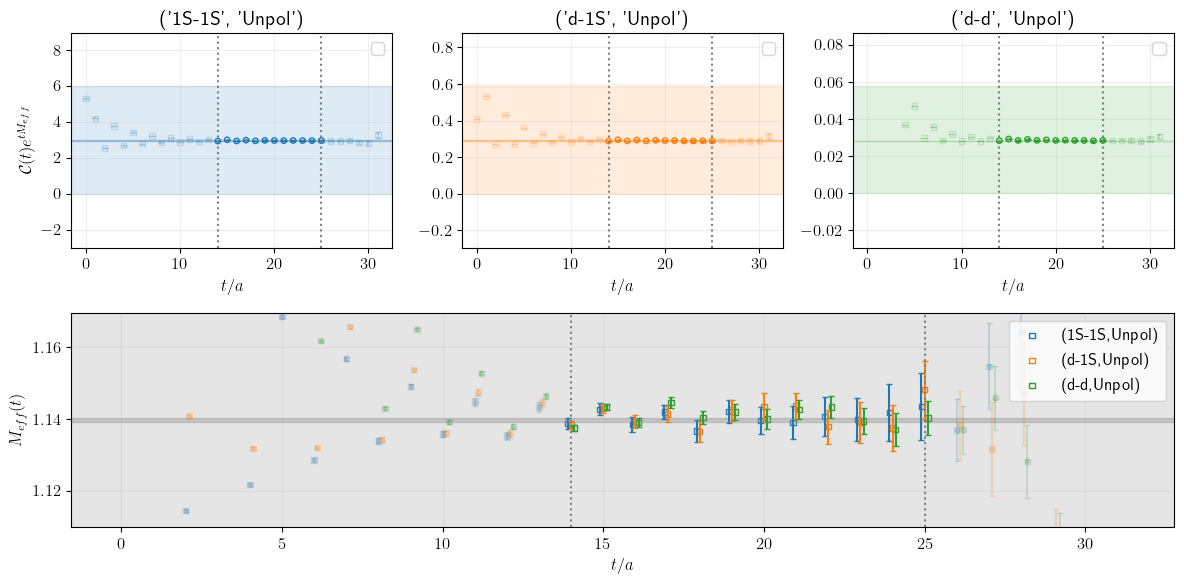

In [9]:
POL = list(corr.data.polarization.values)

(X,meff,aeff), MEFF, AEFF, Mpr, Apr = corr.EffectiveCoeff(
    trange=trange, 
    variant='log', 
    verbose=False, 
    smearing=['1S-1S','d-d','d-1S'],
    aprior=apr,
    mprior=mpr
    )

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.figure(figsize=(12, 6 if len(POL)==1 else 8))


NROWS = len(POL)+1

# Effective coeffs -------------------------------------------------------------------------------
for i,(k,x) in enumerate(X.items()):
    axj = plt.subplot(NROWS,3,i+1)

    # Points inside the fit
    iok = [j for j,x in enumerate(x) if x>=min(trange) and x<=max(trange)]
    xplot = x[iok]
    yplot = gv.mean(aeff[k][iok])
    yerr  = gv.sdev(aeff[k][iok])
    axj.scatter(xplot,yplot, marker='o', s=15 ,facecolors='none', edgecolors=f'C{i}')
    axj.errorbar(xplot,yplot, yerr=yerr,fmt=',',color=f'C{i}', capsize=2)

    # Points outside the fit
    iout = [j for j,x in enumerate(x) if x<min(trange) or x>max(trange)]
    xplot = x[iout]
    yplot = gv.mean(aeff[k][iout])
    yerr  = gv.sdev(aeff[k][iout])
    axj.scatter(xplot,yplot, marker='s', s=15 ,facecolors='none', edgecolors=f'C{i}' ,alpha=0.2)
    axj.errorbar(xplot,yplot, yerr=yerr, fmt=',',color=f'C{i}', capsize=2,alpha=0.2)
    
    # Prior
    axj.axhspan(Apr[k].mean+Apr[k].sdev,Apr[k].mean-Apr[k].sdev,color=f'C{i}',alpha=0.14)

    # Final result
    axj.axhspan(AEFF[k].mean+AEFF[k].sdev,AEFF[k].mean-AEFF[k].sdev,color=f'C{i}',alpha=0.3)#,label=AEFF[k])

    # Delimiter for timespan
    axj.axvline(min(trange),color='gray',linestyle=':')
    axj.axvline(max(trange),color='gray',linestyle=':')

    # # Delimiter on y axis
    # dispersion = abs(gv.mean(aeff[k][iok]) - gv.mean(aeff[k][iok]).mean()).mean()
    dispersion = 2*Apr[k].sdev
    axj.set_ylim(ymax=AEFF[k].mean+dispersion,ymin=AEFF[k].mean-dispersion)

    axj.grid(alpha=0.2)
    axj.title.set_text(k)
    axj.legend()

    axj.set_xlabel(r'$t/a$')
    if i%3==0:
        axj.set_ylabel(r'$\mathcal{C}(t)e^{tM_{eff}}$')

# Effective mass -------------------------------------------------------------------------------
ax = plt.subplot(NROWS,1,NROWS)
for i,(k,y) in enumerate(meff.items()):
    mar = 's' if k[1]=='Unpol' else '^' if k[1]=='Par' else 'v'
    col = f'C{i}'

    # Plot point for the fit considered range
    iok = [j for j,x in enumerate(X[k]) if x>=min(trange) and x<=max(trange)]
    xplot = X[k][iok]
    yplot = gv.mean(y[iok])
    yerr  = gv.sdev(y[iok])
    ax.scatter(xplot+(-0.1 + 0.1*i), yplot, marker=mar, s=15 ,facecolors='none', edgecolors=col, label=f'({k[0]},{k[1]})')
    ax.errorbar(xplot+(-0.1 + 0.1*i),yplot, yerr=yerr, fmt=',' ,color=col, capsize=2)

    # Plot point outside considered range
    iout = [j for j,x in enumerate(X[k]) if x<min(trange) or x>max(trange)]
    xplot = X[k][iout]
    yplot = gv.mean(y[iout])
    yerr  = gv.sdev(y[iout])
    ax.scatter(xplot+0.1*i,yplot, marker=mar, s=15, facecolors='none', edgecolors=f'C{i}',color=col,alpha=0.2)
    ax.errorbar(xplot+0.1*i,yplot,yerr=yerr,fmt='.',color=f'C{i}',alpha=0.2, capsize=2)

# Prior
ax.axhspan(mpr.mean+mpr.sdev,mpr.mean-mpr.sdev,color=f'gray',alpha=0.2)

# Final result
ax.axhspan(MEFF.mean+MEFF.sdev,MEFF.mean-MEFF.sdev,color=f'gray',alpha=0.3)#,label=MEFF)

# Delimiter for the timerange
ax.axvline(min(trange),color='gray',linestyle=':')
ax.axvline(max(trange),color='gray',linestyle=':')

# Limit on y
dispersion = (gv.mean(aeff[k]) - gv.mean(aeff[k]).mean()).mean()
# ax.set_ylim(ymax=AEFF[k].mean+1.5*dispersion,ymin=AEFF[k].mean-1.5*dispersion)
ax.set_ylim(ymin=1.45,ymax=1.6)

ax.legend(loc='upper right')
ax.grid(alpha=0.2)
ax.set_ylim(ymax=MEFF.mean+0.03,ymin=MEFF.mean-0.03)
ax.set_xlabel(r'$t/a$')
ax.set_ylabel(r'$M_{eff}(t)$')

plt.tight_layout()
plt.savefig(f'{plotdir}/2pts_effmass_{tag}.pdf')

# Single fit

In [10]:
MEFF

1.13970(49)

In [12]:
smlist = ['1S-1S','d-d','d-1S']
scemo = CorrFitter(corr, smearing=smlist)

nstates = 3

scemo.fit(
    Nstates=nstates,
    trange=tuple(tLim[ens][meson][mom]),
    verbose=True,
    pval=True,
    # priors = scemo.set_priors_phys(nstates,Meff=MEFF)
    priors = scemo.set_priors_phys(nstates)
)

---------- 3+3 fit in (14, 25) for mes: Dsst of ens: Coarse-1 for mom: 000 --------------
 De-augmented chi2 = 23.24234022899293 with p-value = 0.08656728533781245
Least Square Fit:
  chi2/dof [dof] = 0.7 [36]    Q = 0.91    logGBF = 972.02

Parameters:
            E 0    1.14041 (66)      [ 1.148 (27) ]  
              1      -1.56 (30)      [ -0.8 (2.6) ]  
              2      -1.29 (31)      [ -1.12 (33) ]  
              3      -1.13 (31)      [ -1.12 (33) ]  
              4      -1.11 (33)      [ -1.12 (33) ]  
              5      -1.12 (33)      [ -1.12 (33) ]  
   Z_1S_Unpol 0     0.5492 (45)      [    0 ± 1.2 ]  
              1      -0.13 (47)      [ -1.2 (1.2) ]  
              2       0.19 (87)      [  0.5 (1.5) ]  
              3       0.5 (1.5)      [  0.5 (1.5) ]  
              4       0.5 (3.0)      [  0.5 (3.0) ]  
              5       0.5 (3.0)      [  0.5 (3.0) ]  
 Z_d-1S_Unpol 0   0.005 (1.617)      [  0.5 (1.7) ]  
              1       0.87 (63)      [  0.5 

# Fit range analysis

In [13]:
smlist = ['1S-1S','d-d','d-1S']
fitter = CorrFitter(corr, smearing=smlist)

#### Choose $t_\text{max}$

$t_\text{max}$ has to be chosen such that fitted points have fractional errors $<20/30\%$

In [14]:
tmax    = []
smlist  = ['1S-1S','d-d','d-1S']
pollist = corr.data.polarization.values
for sm in smlist:
    for pol in pollist:
        k = (sm,pol)
        (T,C) = corr.format(smearing=[k[0]],polarization=[k[1]])
        l20 = [t for (t,x) in enumerate(gv.sdev(C[k])/gv.mean(C[k])*100) if x>20]
        
        if l20:
            print(k,'t_max =',min(l20))
            tmax.append(min(l20))
        else:
            print(k,'t_max =',max(T[k]),' (max reached)')
            tmax.append(max(T[k]))

TMAX = min(tmax)
print(f'# --------------------------------')
print(f'#            T_max = {TMAX}       ')
print(f'# --------------------------------')

('1S-1S', 'Unpol') t_max = 31  (max reached)
('d-d', 'Unpol') t_max = 31  (max reached)
('d-1S', 'Unpol') t_max = 31  (max reached)
# --------------------------------
#            T_max = 31       
# --------------------------------


#### Explore $t_\text{max}$ and $N_\text{exc}$

In [15]:
for nstates in [1,2,3]:
    for tmin in np.arange(7,15):
        # trange = (tmin,TMAX)
        trange = (tmin,max(tuple(tLim[ens][meson][mom])))
        try:
            fitter.fit(
                Nstates=nstates,
                trange=trange,
                verbose=True,
                pval=True,
                priors = fitter.set_priors_phys(nstates,Meff=MEFF)
            )
        except ValueError:
            print(nstates,tmin)
        
        print(f'-------------- {nstates} - {tmin} --------------- ')

---------- 1+1 fit in (7, 25) for mes: Dsst of ens: Coarse-1 for mom: 000 --------------
 De-augmented chi2 = 15518.6860178002 with p-value = 0.0
Least Square Fit:
  chi2/dof [dof] = 2.7e+02 [57]    Q = 0    logGBF = -6374.5

Parameters:
            E 0    1.15886 (19)      [ 1.140 (27) ]  
              1    -1.1203 (49)      [ -0.8 (2.6) ]  
   Z_1S_Unpol 0    0.61487 (67)      [    0 ± 1.2 ]  
              1     0.3606 (61)      [ -1.2 (1.2) ]  *
    Z_d_Unpol 0   -1.65624 (71)      [ -1.93 (39) ]  
              1    -1.5624 (56)      [ -3.0 (1.5) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 11/0.0)
  fitter = scipy_least_squares    method = trf

-------------- 1 - 7 --------------- 
---------- 1+1 fit in (8, 25) for mes: Dsst of ens: Coarse-1 for mom: 000 --------------
 De-augmented chi2 = 3459.549630744197 with p-value = 5.4853382835879184e-272
Least Square Fit:
  chi2/dof [dof] = 64 [54]    Q = 0    logGBF = -391.28

Parameters:
           

In [16]:
klist = None
# klist = [k for k in fitter.fits if not (k[0]==3 or k[0]==2 and k[1][0]==14)]
e0,syst = fitter.model_average(keylist=klist)

NameError: name 'plotdir' is not defined

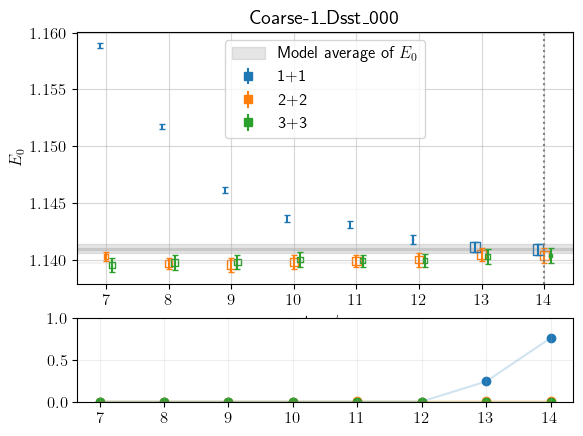

In [17]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, (ax, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
# f, ax = plt.subplots(1, 1)


pnorm = sum([fit.pvalue for fit in fitter.fits.values()])

# ============================================= PLOT ENERGY VALUES =============================================
# Energy plot for different tmin and Nexc
for nexc in [1,2,3]:
    E0 = [f.p['E'][0] for k,f in fitter.fits.items() if k[0]==nexc]
    pvaln = [f.pvalue for k,f in fitter.fits.items() if k[0]==nexc]/pnorm*500
    xplot = np.array([k[1][0] for k,f in fitter.fits.items() if k[0]==nexc])
    yplot = gv.mean(E0)
    yerr  = gv.sdev(E0)

    ax.scatter( xplot+(-0.1 + 0.1*(nexc-1)), yplot, marker='s', s=pvaln ,facecolors='none', edgecolors=f'C{nexc-1}')
    ax.errorbar(xplot+(-0.1 + 0.1*(nexc-1)), yplot, yerr=yerr, fmt=',' ,color=f'C{nexc-1}', capsize=2)
    ax.errorbar([], [], yerr=[], fmt='s' ,color=f'C{nexc-1}', capsize=2, label=f'{nexc}+{nexc}')

# Plot model average
ax.axhspan(e0.mean+e0.sdev,e0.mean-e0.sdev,color='gray',alpha=0.2,label=r'Model average of $E_0$')
ax.axhspan(e0.mean+syst,e0.mean-syst,color='gray',alpha=0.2)

# Plot prior
Epr = fitter.fits[2,tuple(tLim[ens][meson][mom])].prior['E'][0]
# ax.axhspan(Epr.mean+Epr.sdev,Epr.mean-Epr.sdev,color='black',alpha=0.2,label='prior')
ax.axhline(Epr.mean,alpha=0.1,color='gray')


# Plot final tmin line
ax.axvline(min(tuple(tLim[ens][meson][mom])),color='gray',linestyle=':')


# Limits in y
# ax.set_ylim(ymax=1.38,ymin=1.36)

ax.grid(alpha=0.5)
ax.set_xlabel(r'$t_{min}/a$')
ax.set_ylabel(r'$E_0$')
ax.legend()

ax.set_title(tag)


# ======================================= PLOT WEIGHTS =======================================
a1.grid(alpha=0.2)

norm = sum([fitter.weight(nexc,trange) for (nexc,trange),fit in fitter.fits.items()])

for nexc in [1,2,3]:
    x = [min(trange) for (n,trange),f in fitter.fits.items() if n==nexc]
    w = [fitter.weight(*k)/norm for k,f in fitter.fits.items() if k[0]==nexc]
    a1.scatter(x,w)
    a1.plot(x,w,alpha=0.2)

a1.set_ylim(ymin=0,ymax=1)



plt.savefig(f'{plotdir}/2pts_modelav_{ens}_{meson}_{mom}.pdf')

#### Final results for energy

In [18]:
e0_syst = gv.gvar(e0.mean,syst) 
print(f'E_0 for ens. {ens}, meson {meson} at mom {mom} is  {e0} [syst. {e0_syst}]\n')

with open('modav.dat','a') as w:
    w.write(f'E_0 for ens. {ens}, meson {meson} at mom {mom} is  {e0} [syst. {e0_syst}]\n')

E_0 for ens. Coarse-1, meson Dsst at mom 000 is  1.14099(39) [syst. 1.140992(96)]



# Domande
- gli errori dentro `format` devono essere divisi per il numero di configurazioni?

- gli errori sono piccolissimi, non è mai possibile usare il criterio dell'errore al 30%
  
- i p-value vengono tutti estremamente piccoli

- la model average discrimina un po' demmerda

- priori: conversione to physical units con `dscale`. Errore su $E_0$



# Osservazioni
- come va calcolato l'errore? (se uso `np.cov` devo dividere per il numero di configurazioni?)

# Text for priors

We have to write a function that automatically decides the values for the priors of the fit. Let's treat separately the case of energies and overlap factors.

### Energies
There are several things to account for: prior widths and $\Delta E$ in energies. We will use the following rules of thumb:
- The prior for the **fundamental physical state at zero momentum** is set with the effective mass, while its width is set following the paper to $140\text{ MeV}$
  $$
    \tilde{E}_0(\mathbf{p}=0) = M_\text{eff} \pm 140\text{ MeV}
  $$ 
- At **non-zero momentum** 
  $$
    \tilde{E}_0(\mathbf{p}\neq0) = \sqrt{M_\text{eff}^2+\mathbf{p}^2} \pm (140\text{ MeV} + \#\alpha_sa^2\mathbf{p}^2)
  $$ 
- The energy priors for the energy differences are $\Delta \tilde E = 500(200) \text{ MeV}$

### Overlap factor
We will use the following rules
- For non-mixed smearing, physical fund. state, we use the plateaux of $\mathcal{C}(t)e^{tM_\text{eff}}=A_\text{eff}(t)$
$$
  \tilde Z_0^{(\text{sm},\text{pol})} = \sqrt{A_\text{eff}} \, \pm (0.5 \,\mathtt{if\,[p=0]\,else}\,?)
$$
- For non-mixed smearing, oscillating fund. state, we use
$$
  \tilde Z_1^{(\text{sm},\text{pol})} = \sqrt{A_\text{eff}} \, \pm (1.2 \,\mathtt{if\,[p=0]\,else}\,2.0)
$$
- For mixed smearing, excited states, we always use
$$
  \tilde Z_{n\geq2}^{(\text{sm},\text{pol})} = 0.5 \pm 1.5
$$